# Tarea: Análisis Visual de Ventas de Tienda de Conveniencia

### **Equipo:** [Inserte nombres de los integrantes]
### **Grupo:** [Inserte número de grupo]
### **Curso:** Visualización de Datos en Python

## Descripción del Caso

Una cadena de tiendas de conveniencia quiere analizar sus ventas y el comportamiento de los clientes para mejorar su estrategia de marketing. Para ello, han recopilado un conjunto de datos que incluye información sobre las ventas, los productos y los clientes. Su misión será usar las técnicas de visualización de datos aprendidas para analizar y presentar los resultados de este conjunto de datos.

## Indicaciones Generales

1.  **Dataset:** Utilizarán el dataset "Supermarket Sales" disponible en Kaggle (data.csv).
2.  **Entorno:** Trabajen según las indicaciones de este notebook.
3.  **Colaboración:** Esta es una tarea grupal. Asegúrense de coordinar el trabajo.
4.  **Streamlit:** Se requiere crear un dashboard interactivo usando la librería Streamlit. Deberán escribir y ejecutar su código como script the python (archivo .py), pero deben también escribir el código en una celda dentro de éste jupyter notebook para su revisión.
5.  **Pensamiento Crítico:** Incluyan reflexiones y justificaciones para sus elecciones de visualización y análisis.
6.  **Entrega:** Entreguen este notebook completado según las indicaciones.

In [446]:
pip install scipy streamlit matplotlib seaborn fitter

Note: you may need to restart the kernel to use updated packages.


In [447]:
# ----- *** Cargar ficheros y modulos necesarios *** -----
import streamlit as st
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, shapiro, ttest_ind
%matplotlib inline
# -------------------------------------------------------- Fin de carga de modulos

In [448]:
# ----- *** Metodos personalizados *** -----

# ----- *** Funcion para cargar los datos *** -----
# Función con pandas
def load_data_pandas():

    try:
        df = pd.read_csv('/home/diegonalli/Escritorio/Diplomado/data.csv')
    except FileNotFoundError:
        st.error("El archivo no se encuentra en la ruta especificada.")
        return None
    except pd.errors.EmptyDataError:
        st.error("El archivo está vacío.")
        return None
    except pd.errors.ParserError:
        st.error("Error al analizar el archivo CSV.")
        return None
    except Exception as e:
        st.error(f"Error inesperado: {e}")
        return None

    start = time.time()
    df = pd.read_csv('/home/diegonalli/Escritorio/Diplomado/data.csv')
    end = time.time()
    print(f"[pandas] Tiempo de carga: {end - start:.4f} segundos")
    return df
# -------------------------------------------------------- Fin de carga de datos

# ----- *** Función para obtener información de las columnas *** -----
def info_columnas(df, columnas, n=5):
    """
    Función para obtener información sobre las columnas de un DataFrame de pandas.
    Parámetros:
    - df: DataFrame de pandas.
    - columnas: lista de nombres de columnas a analizar.
    - n: número de registros a mostrar (por defecto 5).
    Devuelve un DataFrame con la información solicitada.
    """
    start = time.time()
    info_cols = pd.DataFrame({
        'Tipo de dato': df[columnas].dtypes,
        'Valores nulos': df[columnas].isnull().sum(),
        'Valores únicos': df[columnas].nunique(),
        'Primeros 5 valores': [df[col].head(n).values for col in columnas]
    })
    end = time.time()
    print(f"[pandas] Tiempo de análisis: {end - start:.4f} segundos")

    return info_cols
# -------------------------------------------------------- Fin de función para obtener información de las columnas

# ----- *** Funcion para realizar la prueba Chi-cuadrado a una variable especifica para determinar si la distribucion es uniforme *** -----
def chi_cuadrado(df, variable):
    """
        Definicion: Realiza la prueba Chi-cuadrado para evaluar si una variable categórica tiene una distribución uniforme.
        Parámetros:
        - df: DataFrame de pandas.
        - variable: nombre de la variable a analizar.
        Devuelve el estadístico Chi-cuadrado y el p-valor.
    """
    start = time.time()
    frecuencias = df[variable].value_counts().values
    n = frecuencias.sum()
    k = len(frecuencias)
    esperadas = [n / k] * k

    # Prueba Chi-cuadrado
    stat, p_value = chisquare(frecuencias, f_exp=esperadas)

    end = time.time()
    print(f"[scipy] Tiempo de análisis: {end - start:.4f} segundos")

    return stat, p_value
# -------------------------------------------------------- Fin de función Chi-cuadrado

# ----- *** Funcion para determinar que estan distribuidos normalmente *** -----
def normalidad(df, variable):
    """
        Definicion: Realiza la prueba de normalidad de Shapiro-Wilk para evaluar si una variable sigue una distribución normal.
        Parámetros:
        - df: DataFrame de pandas.
        - variable: nombre de la variable a analizar.
        Devuelve el estadístico W y el p-valor.
    """
    start = time.time()
    stat, p_value = shapiro(df[variable])
    end = time.time()
    print(f"[scipy] Tiempo de análisis: {end - start:.4f} segundos")
    return stat, p_value
# -------------------------------------------------------- Fin de función normalidad

# ----- *** Comparar el gasto entre tipos de clientes usando t-test *** -----
def comparar_gasto_ttest(df, dato_1, dato_2):
    """
    Realiza una prueba t de Student para comparar el gasto entre dos tipos de clientes.
    Parámetros:
    - df: DataFrame de pandas.
    - dato_1: columna categórica.
    - dato_2: columna numérica a comparar.
    Retorna un diccionario con el estadístico t, p-valor y conclusión.
    """
    tipos = df[dato_1].unique()
    if len(tipos) != 2:
        raise ValueError("La columna de tipo de cliente debe tener exactamente dos categorías.")
    grupo1 = df[df[dato_1] == tipos[0]][dato_2]
    grupo2 = df[df[dato_1] == tipos[1]][dato_2]
    t_stat, p_val = ttest_ind(grupo1, grupo2, equal_var=False)
    conclusion = "Sí hay diferencia significativa" if p_val < 0.05 else "No hay diferencia significativa"
    return {
        'Tipo 1': tipos[0],
        'Tipo 2': tipos[1],
        't-stat': t_stat,
        'p-valor': p_val,
        'Conclusión': conclusion
    }
# -------------------------------------------------------- Fin de comparación de gasto entre tipos de clientes


# ----- Histograma de las variables numéricas -----
def histograma_numericas(df, variables):
    """
        Definicion: Genera histogramas para las variables numéricas especificadas.
        Parámetros:
        - df: DataFrame de pandas.
        - variables: lista de nombres de variables a graficar.
    """
    for var in variables:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[var], bins=30, kde=True)
        plt.title(f'Histograma de {var}')
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
        plt.grid()
        plt.show()
# -------------------------------------------------------- Fin de histograma

# ---- *** Crear grafico de ventas por dia *** -----
def ventas_por_dia(df):
    """
        Definicion: Genera un gráfico de líneas que muestra las ventas totales por día y una línea de promedio diario.
        Parámetros:
        - df: DataFrame de pandas.
    """
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Total'] = df['Total'].astype(float)
    ventas_diarias = df.groupby(df['DateTime'].dt.date)['Total'].sum().reset_index()
    promedio_diario = ventas_diarias['Total'].mean()
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=ventas_diarias, x='DateTime', y='Total', label='Ventas diarias')
    plt.axhline(promedio_diario, color='red', linestyle='--', label=f'Promedio diario: {promedio_diario:.2f}')
    plt.title('Ventas Totales por Día')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Totales')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.show()
# -------------------------------------------------------- Fin de gráfico de ventas por día

# ----- *** Crear grafico de ventas por hora *** -----
def ventas_por_hora(df):
    """
        Definicion: Genera un gráfico de líneas que muestra las ventas totales por hora y una línea de promedio por hora.
        Parámetros:
        - df: DataFrame de pandas.
    """
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Total'] = df['Total'].astype(float)
    ventas_horarias = df.groupby(df['DateTime'].dt.hour)['Total'].sum().reset_index()
    promedio_horario = ventas_horarias['Total'].mean()
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=ventas_horarias, x='DateTime', y='Total', label='Ventas por hora')
    plt.axhline(promedio_horario, color='red', linestyle='--', label=f'Promedio por hora: {promedio_horario:.2f}')
    plt.title('Ventas Totales por Hora')
    plt.xlabel('Hora')
    plt.ylabel('Ventas Totales')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.show()
# -------------------------------------------------------- Fin de gráfico de ventas por hora

# ----- *** Funcion que grafica ventas por producto por dia *** -----
def ventas_por_producto(df, producto):
    """
        Definicion: Genera un gráfico de líneas que muestra las ventas totales por día para un producto específico.
        Parámetros:
        - df: DataFrame de pandas.
        - producto: nombre del producto a analizar.
    """
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Total'] = df['Total'].astype(float)
    ventas_producto = df[df['Product line'] == producto].groupby(df['DateTime'].dt.date)['Total'].sum().reset_index()
    promedio_producto = ventas_producto['Total'].mean()
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=ventas_producto, x='DateTime', y='Total', label=f'Ventas de {producto}')
    plt.axhline(promedio_producto, color='red', linestyle='--', label=f'Promedio diario: {promedio_producto:.2f}')
    plt.title(f'Ventas Totales por Día para {producto}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Totales')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.show()
# -------------------------------------------------------- Fin de gráfico de ventas por producto

# ----- *** Funcion que grafica ventas por producto por hora *** -----
def ventas_por_producto_hora(df, producto):
    """
        Definicion: Genera un gráfico de líneas que muestra las ventas totales por hora para un producto específico.
        Parámetros:
        - df: DataFrame de pandas.
        - producto: nombre del producto a analizar.
    """
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Total'] = df['Total'].astype(float)
    ventas_producto_hora = df[df['Product line'] == producto].groupby(df['DateTime'].dt.hour)['Total'].sum().reset_index()
    promedio_producto_hora = ventas_producto_hora['Total'].mean()
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=ventas_producto_hora, x='DateTime', y='Total', label=f'Ventas de {producto}')
    plt.axhline(promedio_producto_hora, color='red', linestyle='--', label=f'Promedio por hora: {promedio_producto_hora:.2f}')
    plt.title(f'Ventas Totales por Hora para {producto}')
    plt.xlabel('Hora')
    plt.ylabel('Ventas Totales')
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.show()
# -------------------------------------------------------- Fin de gráfico de ventas por producto por hora


# --- **** Funcion para graficar la frecuencia de métodos de pago por fecha para el primer mes **** ---
def graficar_frecuencias_payment_mes(frecuencias_payment_fecha,mes):
    """
    Grafica la frecuencia de métodos de pago por fecha para el primer mes del DataFrame frecuencias_payment_fecha.
    """
    # Filtrar el primer mes
    primer_mes = frecuencias_payment_fecha[frecuencias_payment_fecha['Date'].dt.month == mes]

    # Obtener los métodos de pago únicos
    metodos_pago = primer_mes['Método de Pago'].unique()

    plt.figure(figsize=(20, 12))

    for i, metodo in enumerate(metodos_pago, 1):
        plt.subplot(3, 1, i)
        datos_metodo = primer_mes[primer_mes['Método de Pago'] == metodo]
        sns.lineplot(data=datos_metodo, x='Date', y='Frecuencia', marker='o')
        plt.title(f'Frecuencia de {metodo} por Fecha - {mes} mes')
        plt.xlabel('Fecha')
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.grid()

    plt.tight_layout()
    plt.show()
# -------------------------------------------------------- Fin de gráfico de frecuencias de Payment por Fecha

# Función para graficar
def graficar_frecuencias_payment_mes(frecuencias_payment_fecha, mes):
    """
    Grafica la frecuencia de métodos de pago por fecha para el mes especificado.
    """
    # Filtrar por mes
    primer_mes = frecuencias_payment_fecha[frecuencias_payment_fecha['Date'].dt.month == mes]

    # Obtener los métodos de pago únicos
    metodos_pago = primer_mes['Método de Pago'].unique()

    plt.figure(figsize=(20, 12))

    for i, metodo in enumerate(metodos_pago, 1):
        plt.subplot(len(metodos_pago), 1, i)
        datos_metodo = primer_mes[primer_mes['Método de Pago'] == metodo]
        sns.lineplot(data=datos_metodo, x='Date', y='Frecuencia', marker='o')
        plt.title(f'Frecuencia de {metodo} por Fecha - Mes {mes}')
        plt.xlabel('Fecha')
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.grid()

    plt.tight_layout()
    plt.show()
# -------------------------------------------------------- Fin de gráfico de frecuencias de Payment por Fecha


## 1. Selección de Variables y desarrollo de Análisis


a.  Examinen el conjunto de datos proporcionado (`df.info()`, `df.describe()`, `df.columns`).

b.  Identifiquen y **justifiquen** las variables que consideren más relevantes para un análisis significativo del comportamiento de ventas y clientes. 

c.  Reflexionen sobre la importancia de cada variable seleccionada en el contexto del caso de estudio (¿Qué preguntas de negocio pueden ayudar a responder?).

In [449]:
# ----- *** Cargar los datos *** -----
df_pandas = load_data_pandas()
df_pandas.head(5)
# -------------------------------------------------------- Fin de carga de datos

[pandas] Tiempo de carga: 0.0028 segundos


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


### Clasificacion y definicion de columnas

Del analisis anterior, podemos definir entonces las siguientes ccolumnas con su respectiva definicion:

- Categoricas

| Columna         | Definición                                                                                            |
| --------------- | ----------------------------------------------------------------------------------------------------- |
| `Invoice ID`    | Identificador único de cada factura. Es categórica nominal utilizada como ID                          |   
| `Branch`        | Sucursal donde se realizó la compra. Valores: A, B, C.                                                |
| `City`          | Ciudad donde está ubicada la sucursal. Valores: Yangon, Mandalay, Naypyitaw.                          |
| `Customer type` | Tipo de cliente: `Member` (fidelizado) o `Normal` (ocasional).                                        |
| `Gender`        | Género del cliente: `Male` o `Female`.                                                                |
| `Product line`  | Categoría del producto comprado (6 categorías distintas).                                             |
| `Payment`       | Método de pago usado: `Cash`, `Credit card`, `Ewallet`.                                               |


- Numericas

| Columna                   | Definición                                                               |
| ------------------------- | ------------------------------------------------------------------------ |
| `Unit price`              | Precio unitario del producto.                                            |
| `Quantity`                | Cantidad de productos comprados.                                         |
| `Tax 5%`                  | Impuesto aplicado.                                                       |
| `Total`                   | Total pagado por la compra impuesto incluido  .                          |
| `cogs`                    | Costo por producto (cantidad × precio).                                  |
| `gross margin percentage` | Porcentaje de margen bruto (4.76%) en todo el dataset.                   |
| `gross income`            | Ingreso bruto (equivale al impuesto).                                    |
| `Rating`                  | Puntuación de satisfacción del cliente (de 4.0 a 10.0).                  |


- Tempoorales y marktime

| Columna           | Definición                                                    |
| ----------------- | ------------------------------------------------------------- |
| `Date`            | Fecha en la que se realizó la compra.                         |
| `Time`            | Hora en la que se realizó la compra.                          |


In [450]:
# ----- *** Clasificación de columnas por tipo y definición *** -----
# CATEGORICAS
categoricas = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']

# NUMERICAS
numericas = ['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross margin percentage', 'gross income', 'Rating']
numericas_independientes = ['Unit price', 'Quantity', 'Total']

# TEMPORALES
temporales = ['Date', 'Time']
# -------------------------------------------------------- Fin de clasificación de columnas

In [451]:
# ----- *** Descripción de todas las variables *** -----
info_columnas(df_pandas, df_pandas.columns, n=5)
# -------------------------------------------------------- Fin de descripción de los datos

[pandas] Tiempo de análisis: 0.0067 segundos


,Tipo de dato,Valores nulos,Valores únicos,Primeros 5 valores
Invoice ID,object,0,1000,"[750-67-8428, 226-31-3081, 631-41-3108, 123-19..."
Branch,object,0,3,"[A, C, A, A, A]"
City,object,0,3,"[Yangon, Naypyitaw, Yangon, Yangon, Yangon]"
Customer type,object,0,2,"[Member, Normal, Normal, Member, Normal]"
Gender,object,0,2,"[Female, Female, Male, Male, Male]"
Product line,object,0,6,"[Health and beauty, Electronic accessories, Ho..."
Unit price,float64,0,943,"[74.69, 15.28, 46.33, 58.22, 86.31]"
Quantity,int64,0,10,"[7, 5, 7, 8, 7]"
Tax 5%,float64,0,990,"[26.1415, 3.82, 16.2155, 23.288, 30.2085]"
Total,float64,0,990,"[548.9715, 80.22, 340.5255, 489.048, 634.3785]"


In [452]:
# ----- *** Tabla de frecuencias para variables categóricas *** -----

filas = []

# ----- Contar frecuencias para cada variable categórica -----
for col in categoricas:
    conteo = df_pandas[col].value_counts().reset_index()
    conteo.columns = ['Categoría', 'Frecuencia']
    conteo['Porcentaje'] = (conteo['Frecuencia'] / len(df_pandas) * 100).round(2).astype(str) + '%'
    conteo['Variable'] = col
    filas.append(conteo)
# -------------------------------------------------------- Fin de conteo de frecuencias

# ----- Concatenar resultados en un solo DataFrame -----
df_frecuencias = pd.concat(filas, ignore_index=True)
# -------------------------------------------------------- Fin de concatenación

# ----- Ordenar DataFrame por Variable y Categoría -----
df_frecuencias = df_frecuencias[['Variable', 'Categoría', 'Frecuencia', 'Porcentaje']]
# --------------------------------------------------------- Fin de ordenación

# ----- Reemplazar valores duplicados en la columna 'Variable' -----
df_frecuencias['Variable'] = df_frecuencias['Variable'].mask(df_frecuencias['Variable'].duplicated(), '')
# -------------------------------------------------------- Fin de reemplazo

# ----- Resetear el índice del DataFrame -----
df_frecuencias['Categoría'] = df_frecuencias['Categoría'].astype(str)
df_frecuencias['Categoría'] = df_frecuencias['Categoría'].str.replace('nan', 'Sin categoría')
# -------------------------------------------------------- Fin de reset del índice


df_frecuencias


,Variable,Categoría,Frecuencia,Porcentaje
0,Branch,A,340,34.0%
1,,B,332,33.2%
2,,C,328,32.8%
3,City,Yangon,340,34.0%
4,,Mandalay,332,33.2%
5,,Naypyitaw,328,32.8%
6,Customer type,Member,501,50.1%
7,,Normal,499,49.9%
8,Gender,Female,501,50.1%
9,,Male,499,49.9%


In [453]:
# ----- *** Análisis de dispersión y sesgo *** -----
descripcion_estadistica = df_pandas[numericas].describe()
descripcion_estadistica
# -------------------------------------------------------- Fin de análisis de dispersión y sesgo

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


In [454]:
df_pandas.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating'],
      dtype='object')

### _*Selección de Variables Relevantes para el Análisis*_

Para realizar un análisis del comportamiento de ventas y clientes se seleccionan las siguientes variables:

- **Variables Categóricas:**  
    - `Branch`, `City`: Permiten analizar geograficamente (posibles analisis futuros para categorizacion o clusterizacion).
    - `Customer type`: Diferencia entre clientes fidelizados y ocasionales (posibles analisis futuros para categorizacion o clusterizacion).
    - `Gender`: Permite explorar posibles diferencias de comportamiento por género (variables de diferenciacion Z)
    - `Product line`: Permitira identificar productos mas vendidos y su impacto en los ingresos
    - `Payment`: Entender las preferencias de pago de los clientes.

- **Variables Numéricas:**  
    - `Unit price`, `Quantity`, `Total`: Fundamentales para analizar el volumen y valor de las ventas.
    - `gross income`: Permiten evaluar la rentabilidad y el margen de ganancia.
    - `Rating`: Refleja la satisfacción del cliente (KPI de satisfaccion)

- **Variables Temporales:**  
    - `Date`, `Time`: Indispensables para analizar tendencias, patrones temporales y horarios de mayor actividad.

 
Las siguientes variables por considerarse poco relevantes para el análisis solicitado:

- **`Invoice ID`**: Es un id único de cada registro, es muy útil para registro interno, pero no aporta valor para el analisis
- **`Tax 5%`** y **`gross margin percentage`**: Son variables constantes en el dataset. 

## Análisis Requeridos:

1.  **Evolución de las Ventas Totales:**
    *   **Objetivo:** Mostrar cómo han variado las ventas totales (`Total`) a lo largo del tiempo (`Date`).

2.  **Ingresos por Línea de Producto:**
    *   **Objetivo:** Comparar los ingresos (`Total`) generados por cada `Product line`.

3.  **Distribución de la Calificación de Clientes:**
    *   **Objetivo:** Analizar la distribución de las calificaciones (`Rating`) de los clientes.

4.  **Comparación del Gasto por Tipo de Cliente:**
    *   **Objetivo:** Comparar la distribución del gasto total (`Total`) entre clientes `Member` y `Normal`.

5.  **Relación entre Costo y Ganancia Bruta:**
    *   **Objetivo:** Visualizar la relación entre el costo de bienes vendidos (`cogs`) y el ingreso bruto (`gross income`).

6.  **Métodos de Pago Preferidos:**
    *   **Objetivo:** Identificar los métodos de pago (`Payment`) más frecuentes.

7.  **Análisis de Correlación Numérica:**
    *   **Objetivo:** Explorar relaciones lineales entre variables numéricas (`Unit price`, `Quantity`, `Tax 5%`, `Total`, `cogs`, `gross income`, `Rating`).

8.  **Composición del Ingreso Bruto por Sucursal y Línea de Producto:**
    *   **Objetivo:** Mostrar la contribución de cada `Product line` al `gross income` dentro de cada `Branch`.


## Resultados

#### 1.  **Evolución de las Ventas Totales:**

**Objetivo:** Mostrar cómo han variado las ventas totales (`Total`) a lo largo del tiempo (`Date`).

In [455]:
# ----- *** Unir columnas de fecha y hora *** -----
df_pandas['DateTime'] = pd.to_datetime(df_pandas['Date'] + ' ' + df_pandas['Time'])
# -------------------------------------------------------- Fin de unión de columnas

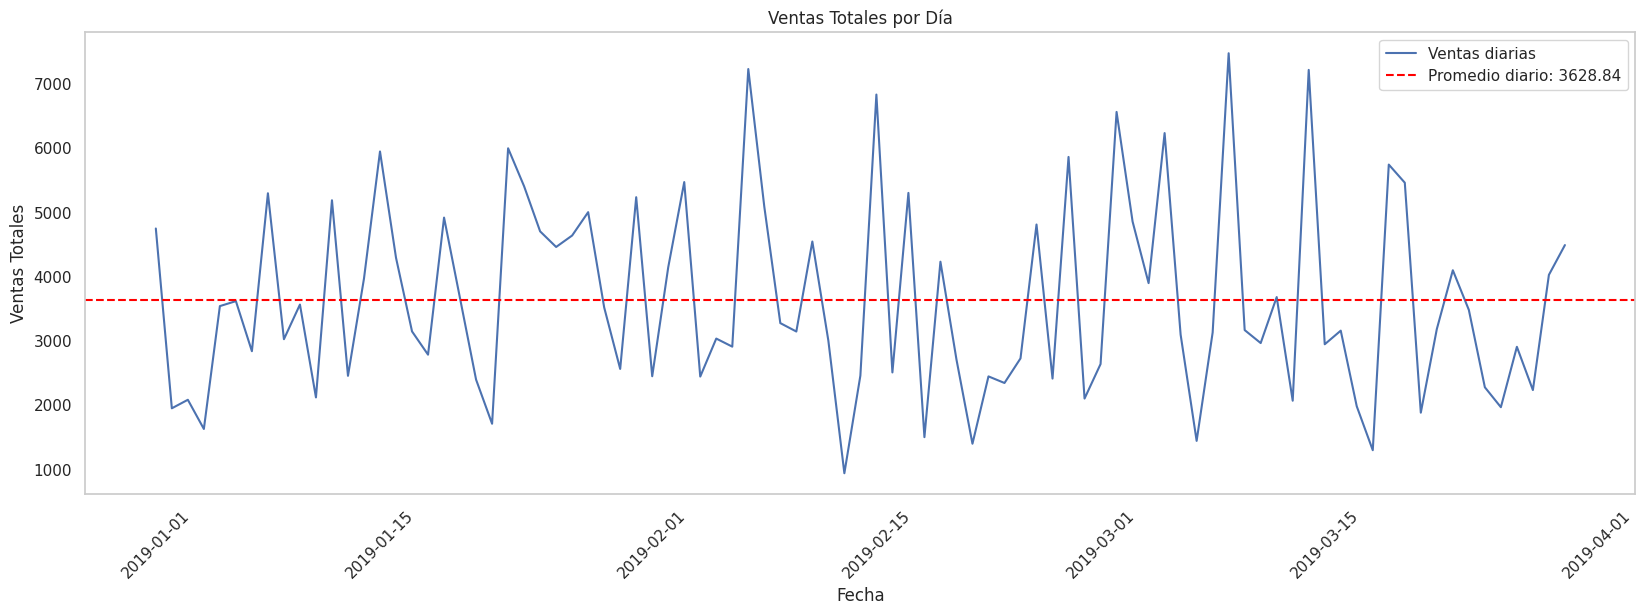

In [456]:
# Mostrar grafico de ventas por hora 
#ventas_por_hora(df_pandas)
ventas_por_dia(df_pandas)

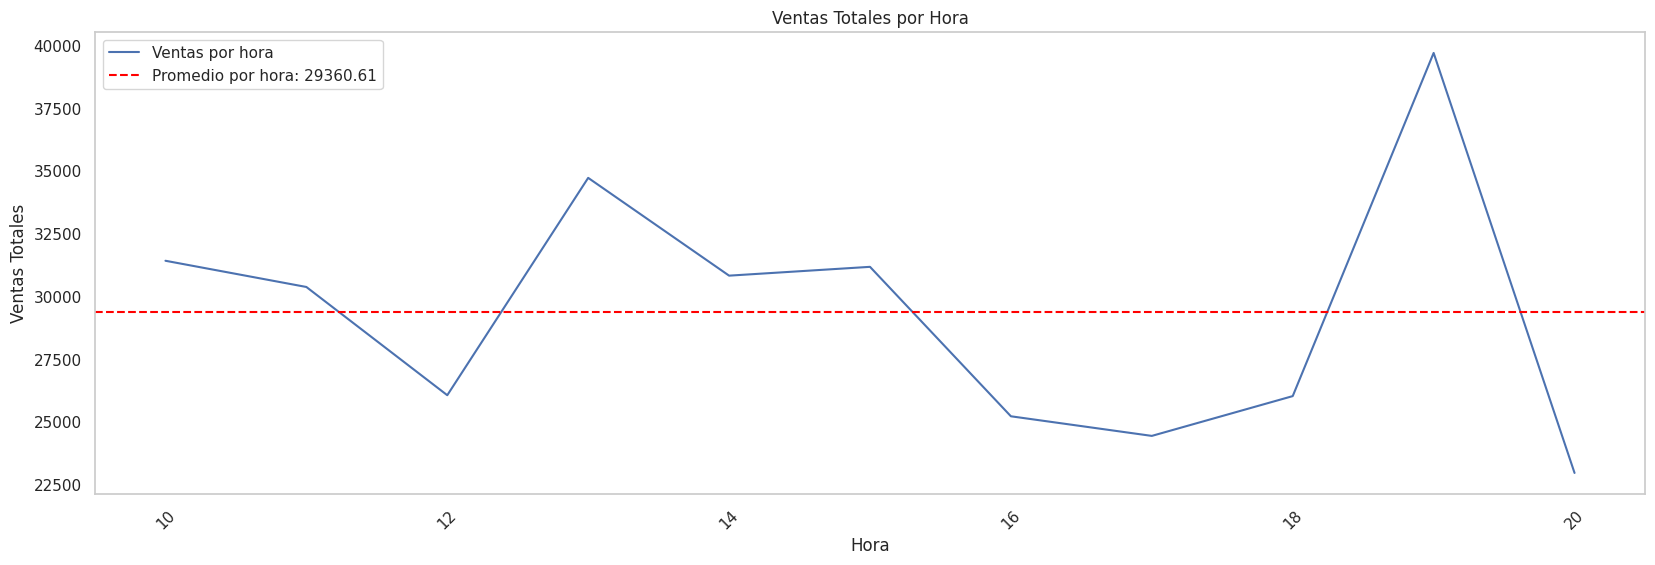

In [457]:
# Mostrar grafico de ventas por hora
ventas_por_hora(df_pandas)

In [458]:
# Crear tabla con valores máximos y mínimos de ventas por día
ventas_por_dia = df_pandas.groupby(df_pandas['DateTime'].dt.date)['Total'].agg(['min', 'max']).reset_index()
ventas_por_dia.columns = ['Fecha', 'Venta Mínima', 'Venta Máxima']
ventas_por_dia['Rango Venta'] = ventas_por_dia['Venta Máxima'] - ventas_por_dia['Venta Mínima']
ventas_por_dia

,Fecha,Venta Mínima,Venta Máxima,Rango Venta
0,2019-01-01,113.5680,888.6150,775.0470
1,2019-01-02,44.5935,383.7645,339.1710
2,2019-01-03,44.3520,520.8000,476.4480
3,2019-01-04,75.7785,629.8425,554.0640
4,2019-01-05,33.4950,690.0180,656.5230
...,...,...,...,...
84,2019-03-26,41.0760,530.6700,489.5940
85,2019-03-27,91.8225,943.2990,851.4765
86,2019-03-28,74.0880,525.2310,451.1430
87,2019-03-29,121.1280,922.6350,801.5070


#### 2.  **Ingresos por Línea de Producto:**

**Objetivo:** Comparar los ingresos (`Total`) generados por cada `Product line`.

In [459]:
# ----- *** Comparar los ingresos Total generados por cada Product line *** -----
ventas_por_producto = df_pandas.groupby(['Product line'])['Total'].agg(['sum', 'mean', 'std']).reset_index()
ventas_por_producto.columns = ['Producto', 'Total Ventas', 'Promedio Ventas', 'Desviación Estándar']
ventas_por_producto['Total Ventas'] = ventas_por_producto['Total Ventas'].round(2)
ventas_por_producto['Promedio Ventas'] = ventas_por_producto['Promedio Ventas'].round(2)
ventas_por_producto['Desviación Estándar'] = ventas_por_producto['Desviación Estándar'].round(2)
ventas_por_producto

,Producto,Total Ventas,Promedio Ventas,Desviación Estándar
0,Electronic accessories,54337.53,319.63,245.95
1,Fashion accessories,54305.90,305.09,243.56
2,Food and beverages,56144.84,322.67,247.16
3,Health and beauty,49193.74,323.64,237.54
4,Home and lifestyle,53861.91,336.64,254.60
5,Sports and travel,55122.83,332.07,248.38


In [460]:
# ----- *** Comparar los ingresos Total generados por cada Product line y Fecha en tabla *** -----
ventas_por_producto_fecha = df_pandas.groupby(['Date', 'Product line'])['Total'].agg(['sum', 'mean', 'std']).reset_index()
ventas_por_producto_fecha.columns = ['Fecha', 'Producto', 'Total Ventas', 'Promedio Ventas', 'Desviación Estándar']
ventas_por_producto_fecha['Total Ventas'] = ventas_por_producto_fecha['Total Ventas'].round(2)
ventas_por_producto_fecha['Promedio Ventas'] = ventas_por_producto_fecha['Promedio Ventas'].round(2)
ventas_por_producto_fecha['Desviación Estándar'] = ventas_por_producto_fecha['Desviación Estándar'].round(2)
ventas_por_producto_fecha
# -------------------------------------------------------- Fin de comparación de ingresos por producto y fecha


,Fecha,Producto,Total Ventas,Promedio Ventas,Desviación Estándar
0,1/1/2019,Electronic accessories,1382.74,460.92,323.38
1,1/1/2019,Fashion accessories,621.24,621.24,NaN
2,1/1/2019,Food and beverages,1066.02,533.01,502.90
3,1/1/2019,Health and beauty,132.03,132.03,NaN
4,1/1/2019,Home and lifestyle,399.76,399.76,NaN
...,...,...,...,...,...
449,3/9/2019,Fashion accessories,2010.90,502.72,353.72
450,3/9/2019,Food and beverages,1459.11,729.56,290.92
451,3/9/2019,Health and beauty,762.55,381.28,232.06
452,3/9/2019,Home and lifestyle,383.52,383.52,NaN


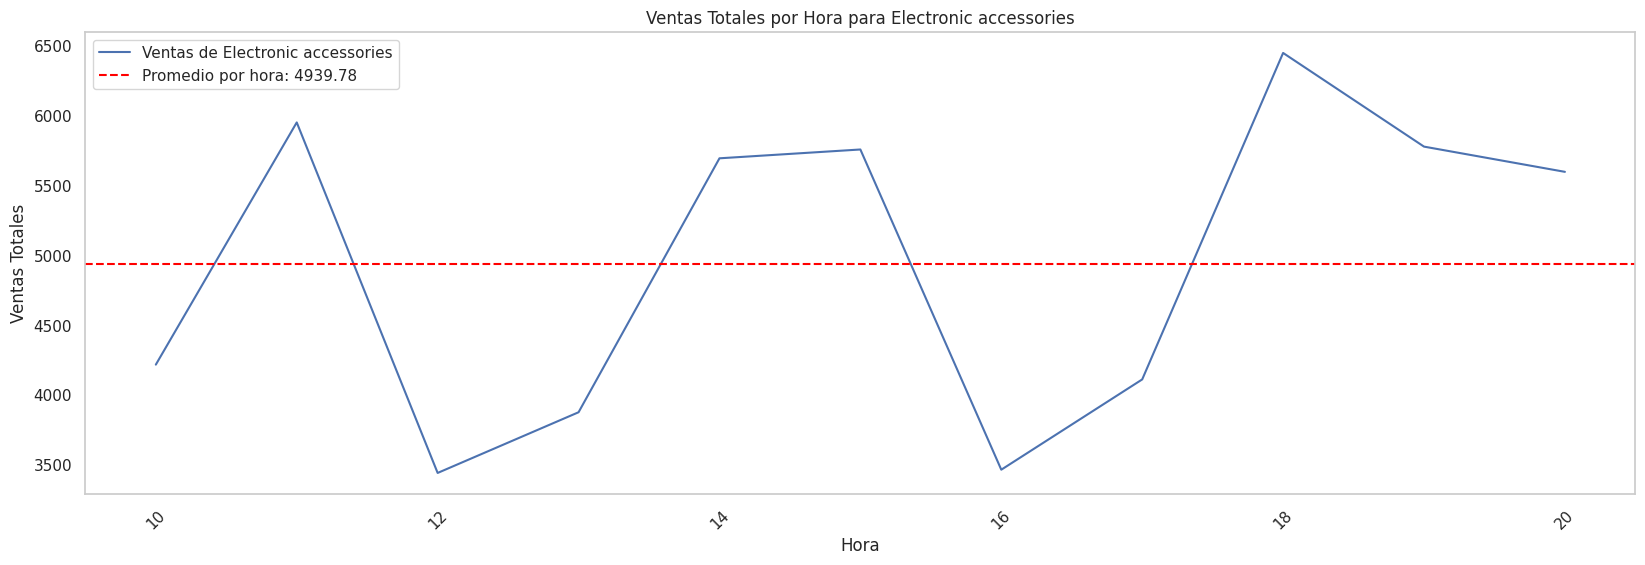

In [461]:
ventas_por_producto_hora(df_pandas, "Electronic accessories")

#### 3.  **Distribución de la Calificación de Clientes:**

**Objetivo:** Analizar la distribución de las calificaciones (`Rating`) de los clientes.

In [462]:
rating_normalidad = chi_cuadrado(df_pandas, 'Rating')
rating_normalidad_df = pd.DataFrame({
    'Estadístico': [rating_normalidad[0]], 
    'p-valor': [rating_normalidad[1]],
    'Distribución Normal': ['Sí' if rating_normalidad[1] > 0.05 else 'No']})
rating_normalidad_df

[scipy] Tiempo de análisis: 0.0010 segundos


,Estadístico,p-valor,Distribución Normal
0,50.786,0.795818,Sí


La prueba de Chi-cuadrado aplicada a la variable `Rating` indica que las calificaciones de los clientes no presentan diferencias significativas respecto a una distribución uniforme (p-valor = 0.796). Esto sugiere que las valoraciones están distribuidas de manera homogénea entre las distintas categorías, sin sesgos notables hacia valores altos o bajos. Por lo tanto, no se identifican patrones atípicos en la satisfacción del cliente según las calificaciones registradas

In [463]:
normalidad = normalidad(df_pandas, 'Rating')
normalidad_df = pd.DataFrame({
    'Estadístico W': [normalidad[0]], 
    'p-valor': [normalidad[1]],
    'Distribución Normal': ['Sí' if normalidad[1] > 0.05 else 'No']})
normalidad_df

[scipy] Tiempo de análisis: 0.0005 segundos


,Estadístico W,p-valor,Distribución Normal
0,0.958201,2.688029e-16,No


La prueba de normalidad de Shapiro-Wilk aplicada a la variable `Rating` muestra un p-valor extremadamente bajo (p < 0.001), lo que indica que las calificaciones de los clientes no siguen una distribución normal. Presentandose existencias de valores altos en ciertas calificaciones de manera asimetrica

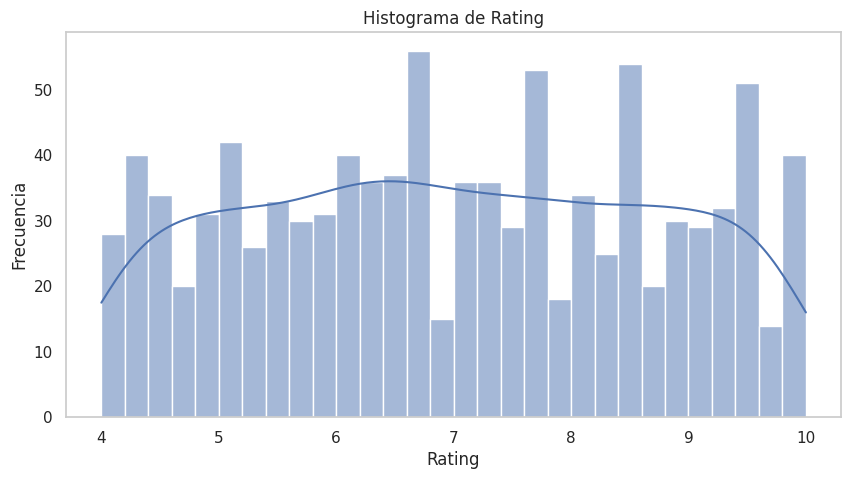

In [464]:
# ----- *** Histograma de la variable Rating *** -----
plt.figure(figsize=(10, 5))
sns.histplot(df_pandas['Rating'], bins=30, kde=True)
plt.title('Histograma de Rating')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()


In [465]:
# ---- *** Top 5 Ratings *** -----
top_5_ratings = df_pandas['Rating'].value_counts().head(4)
top_5_ratings_df = pd.DataFrame({
    'Rating': top_5_ratings.index,
    'Frecuencia': top_5_ratings.values
})
top_5_ratings_df

,Rating,Frecuencia
0,6.0,26
1,6.6,24
2,9.5,22
3,4.2,22


Se puede evidenciar que existen un top 5 de frecuencias de calificaciones Ratings distribuidas en valores lejanos a una distribucio normal y con asimetrias.

#### 4.  **Comparación del Gasto por Tipo de Cliente:**

**Objetivo:** Comparar la distribución del gasto total (`Total`) entre clientes `Member` y `Normal`.

In [466]:
# ---- *** Crear tabla de Total por el tipo de Customer type *** -----
ventas_por_cliente = df_pandas.groupby(['Customer type'])['Total'].agg(['sum', 'mean', 'std']).reset_index()
ventas_por_cliente.columns = ['Tipo de Cliente', 'Total Ventas', 'Promedio Ventas', 'Desviación Estándar']
ventas_por_cliente['Total Ventas'] = ventas_por_cliente['Total Ventas'].round(2)
ventas_por_cliente['Promedio Ventas'] = ventas_por_cliente['Promedio Ventas'].round(2)
ventas_por_cliente['Desviación Estándar'] = ventas_por_cliente['Desviación Estándar'].round(2)
ventas_por_cliente


,Tipo de Cliente,Total Ventas,Promedio Ventas,Desviación Estándar
0,Member,164223.44,327.79,247.99
1,Normal,158743.30,318.12,243.90


In [467]:
# ----- *** Crear tabla de Total por el tipo Customer type y la columna Fecha *** -----
ventas_por_cliente_fecha = df_pandas.groupby(['Date', 'Customer type'])['Total'].agg(['sum', 'mean', 'std']).reset_index()
ventas_por_cliente_fecha.columns = ['Fecha', 'Tipo de Cliente', 'Total Ventas', 'Promedio Ventas', 'Desviación Estándar']
ventas_por_cliente_fecha['Total Ventas'] = ventas_por_cliente_fecha['Total Ventas'].round(2)
ventas_por_cliente_fecha['Promedio Ventas'] = ventas_por_cliente_fecha['Promedio Ventas'].round(2)
ventas_por_cliente_fecha['Desviación Estándar'] = ventas_por_cliente_fecha['Desviación Estándar'].round(2)
ventas_por_cliente_fecha

,Fecha,Tipo de Cliente,Total Ventas,Promedio Ventas,Desviación Estándar
0,1/1/2019,Member,2753.62,458.94,313.23
1,1/1/2019,Normal,1991.56,331.93,210.81
2,1/10/2019,Member,1601.27,320.25,190.22
3,1/10/2019,Normal,1959.68,489.92,292.40
4,1/11/2019,Member,1104.63,276.16,69.33
...,...,...,...,...,...
173,3/7/2019,Normal,1172.41,167.49,114.01
174,3/8/2019,Member,1115.95,371.98,502.27
175,3/8/2019,Normal,2009.44,251.18,157.71
176,3/9/2019,Member,5114.26,511.43,264.50


In [468]:
# Comparar gasto entre tipos de clientes
comparacion_gasto = comparar_gasto_ttest(df_pandas, 'Customer type', 'Total')
comparacion_gasto_df = pd.DataFrame([comparacion_gasto])
comparacion_gasto_df

,Tipo 1,Tipo 2,t-stat,p-valor,Conclusión
0,Member,Normal,0.621548,0.534381,No hay diferencia significativa


La comparación del gasto total entre los tipos de clientes `Member` y `Normal` muestra que no existe una diferencia significativa en el promedio de gasto entre ambos grupos (p-valor = 0.53). Esto indica que, en este conjunto de datos, la membresía no influye de manera relevante en el monto gastado por los clientes. 

#### 5.  **Relación entre Costo y Ganancia Bruta:**

**Objetivo:** Visualizar la relación entre el costo de bienes vendidos (`cogs`) y el ingreso bruto (`gross income`).

> A pesar de que visualmente la relación entre el `cogs` y el `gross income` muestra una correlación lineal perfecta, este comportamiento era esperable, ya que el ingreso bruto se calcula directamente como un porcentaje constante del `cogs`. Por lo tanto, no es necesario evaluar estadísticamente esta relación.  Su comportamiento invalida cualquier inferencia adicional sobre correlación o causalidad.

#### 6.  **Métodos de Pago Preferidos:**

**Objetivo:** Identificar los métodos de pago (`Payment`) más frecuentes.

In [469]:
# ---- *** Identificar frecuencias Payment *** -----
frecuencias_payment = df_pandas['Payment'].value_counts().reset_index()
frecuencias_payment.columns = ['Método de Pago', 'Frecuencia']
frecuencias_payment['Porcentaje'] = (frecuencias_payment['Frecuencia'] / len(df_pandas) * 100).round(2).astype(str) + '%'
frecuencias_payment['Método de Pago'] = frecuencias_payment['Método de Pago'].astype(str)
frecuencias_payment['Método de Pago'] = frecuencias_payment['Método de Pago'].str.replace('nan', 'Sin método de pago')
frecuencias_payment


,Método de Pago,Frecuencia,Porcentaje
0,Ewallet,345,34.5%
1,Cash,344,34.4%
2,Credit card,311,31.1%


In [470]:
# ----- *** Tabla de frecuencias de Payment por Fecha *** -----
frecuencias_payment_fecha = df_pandas.groupby(['Date', 'Payment']).size().reset_index(name='Frecuencia')
frecuencias_payment_fecha['Porcentaje'] = (frecuencias_payment_fecha['Frecuencia'] / len(df_pandas) * 100).round(2).astype(str) + '%'
frecuencias_payment_fecha['Método de Pago'] = frecuencias_payment_fecha['Payment'].astype(str)
frecuencias_payment_fecha['Método de Pago'] = frecuencias_payment_fecha['Método de Pago'].str.replace('nan', 'Sin método de pago')
frecuencias_payment_fecha


,Date,Payment,Frecuencia,Porcentaje,Método de Pago
0,1/1/2019,Cash,6,0.6%,Cash
1,1/1/2019,Credit card,4,0.4%,Credit card
2,1/1/2019,Ewallet,2,0.2%,Ewallet
3,1/10/2019,Cash,3,0.3%,Cash
4,1/10/2019,Credit card,3,0.3%,Credit card
...,...,...,...,...,...
256,3/8/2019,Credit card,3,0.3%,Credit card
257,3/8/2019,Ewallet,5,0.5%,Ewallet
258,3/9/2019,Cash,8,0.8%,Cash
259,3/9/2019,Credit card,5,0.5%,Credit card


La tabla muestra que los métodos de pago mantiene distribución bastante equilibrada entre las tres opciones. 

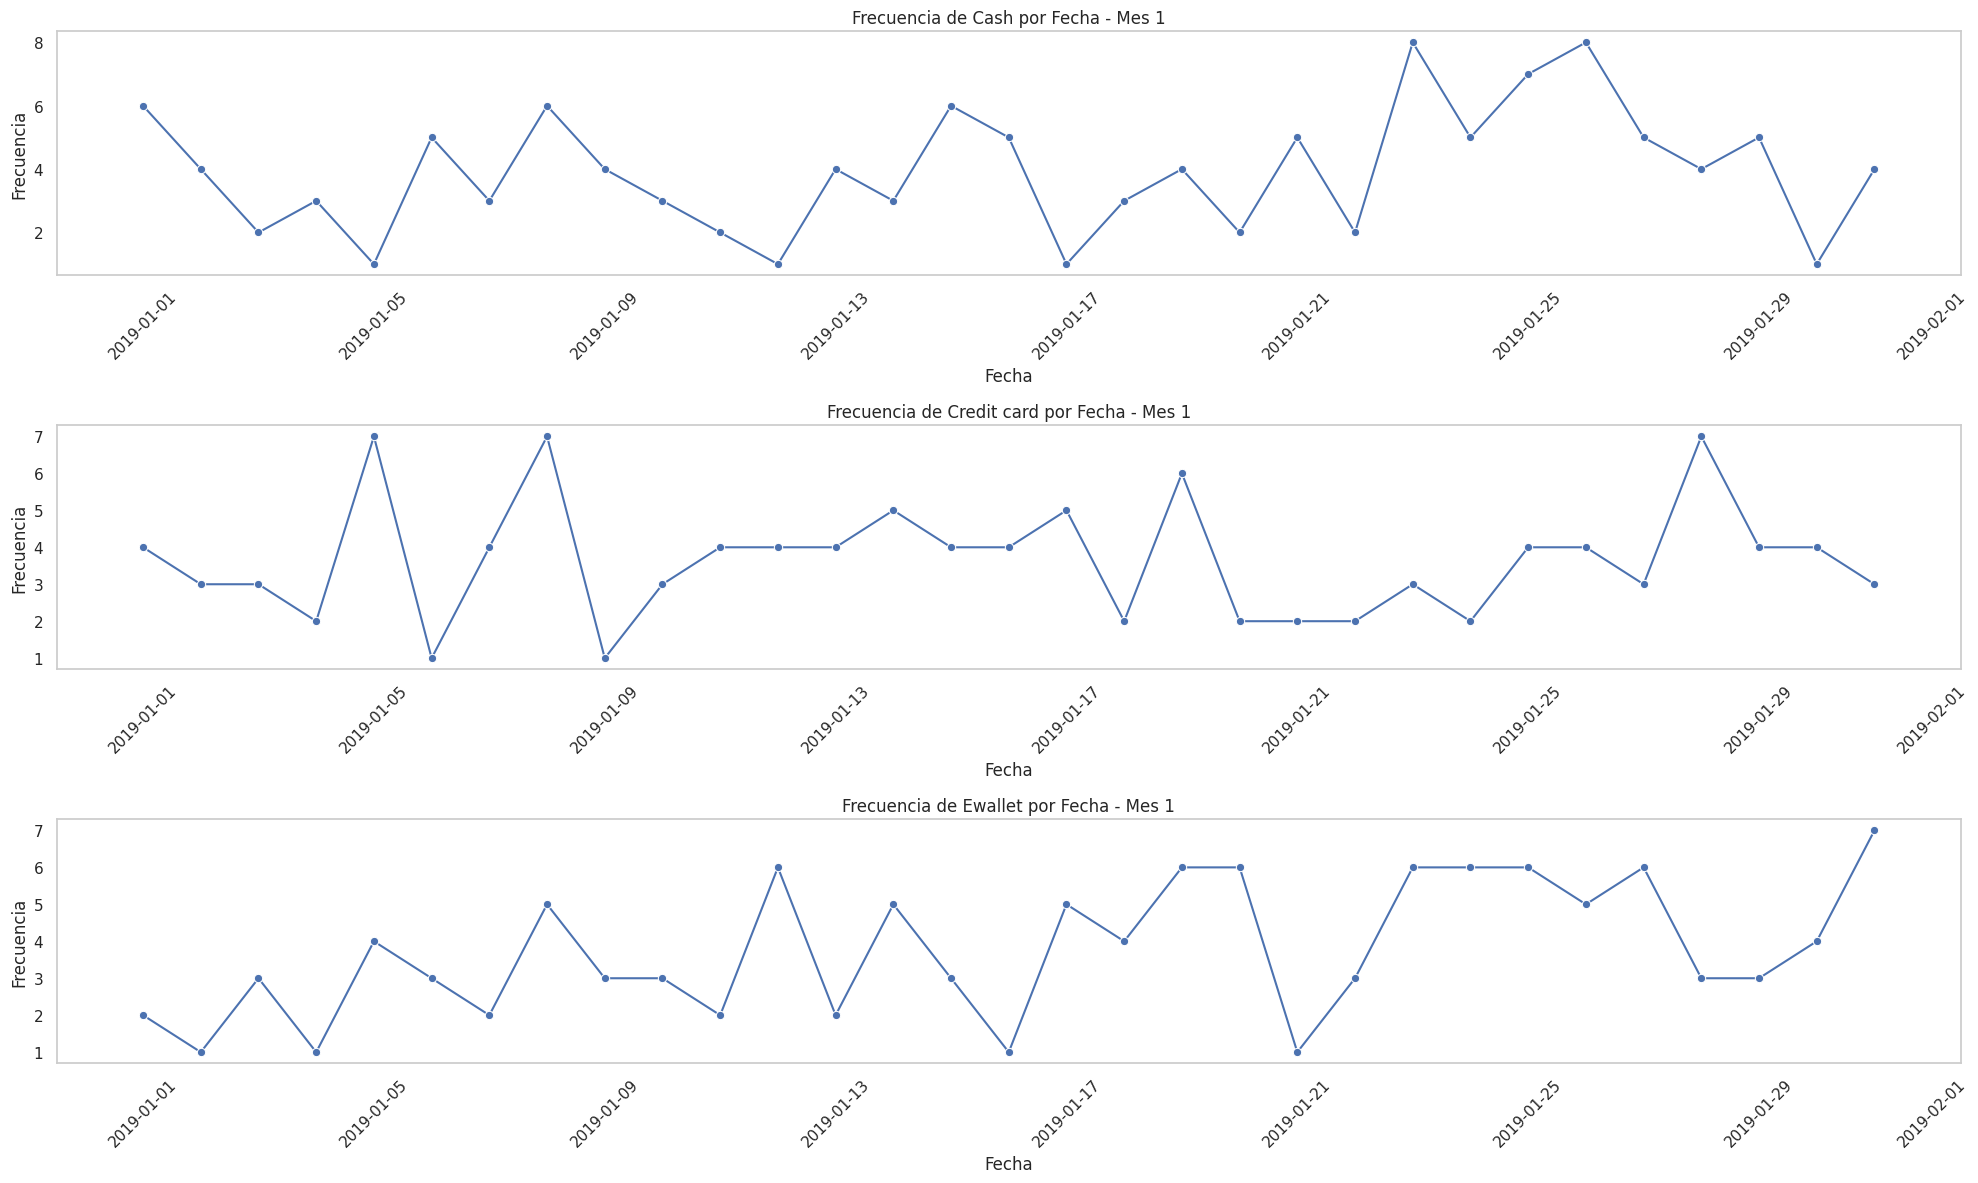

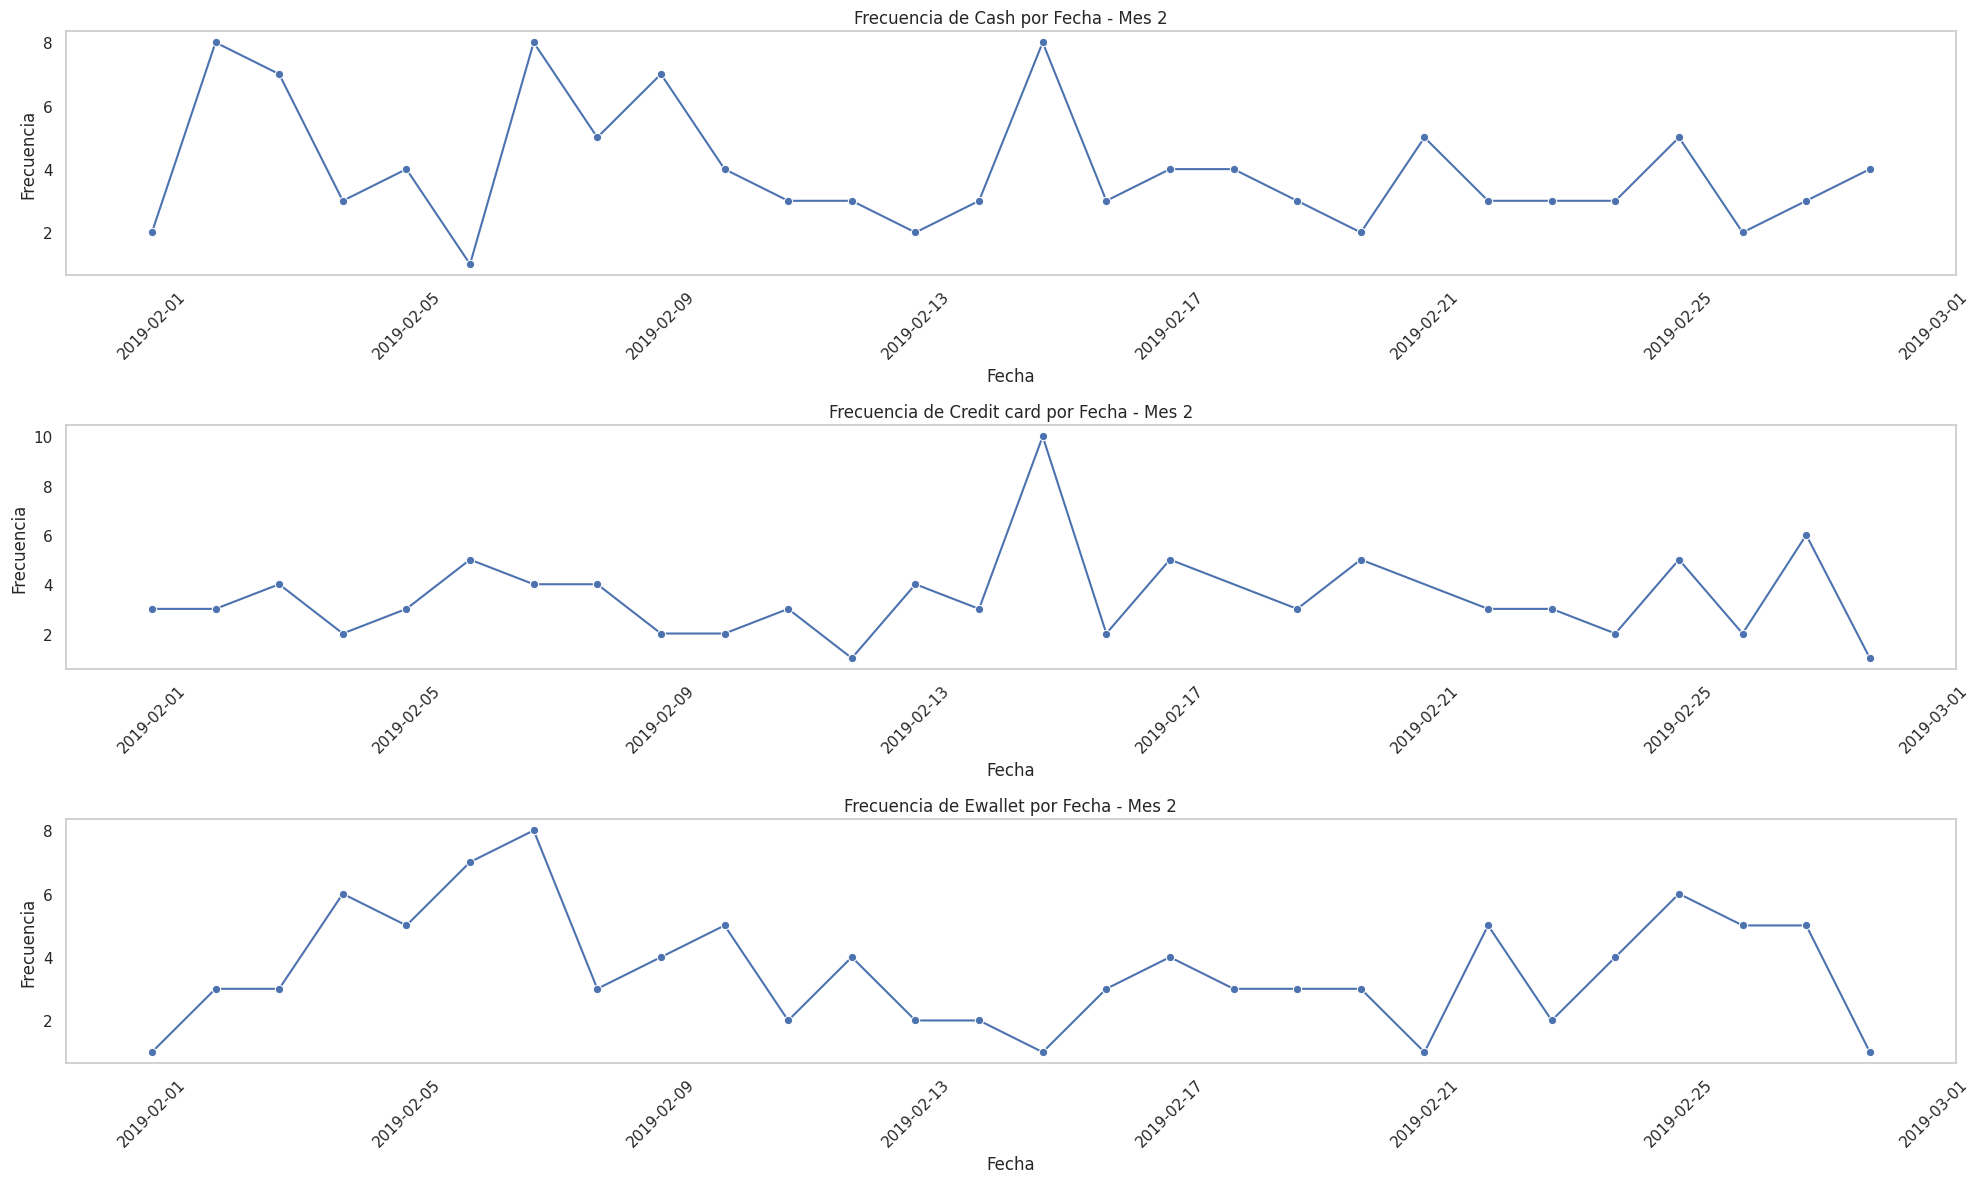

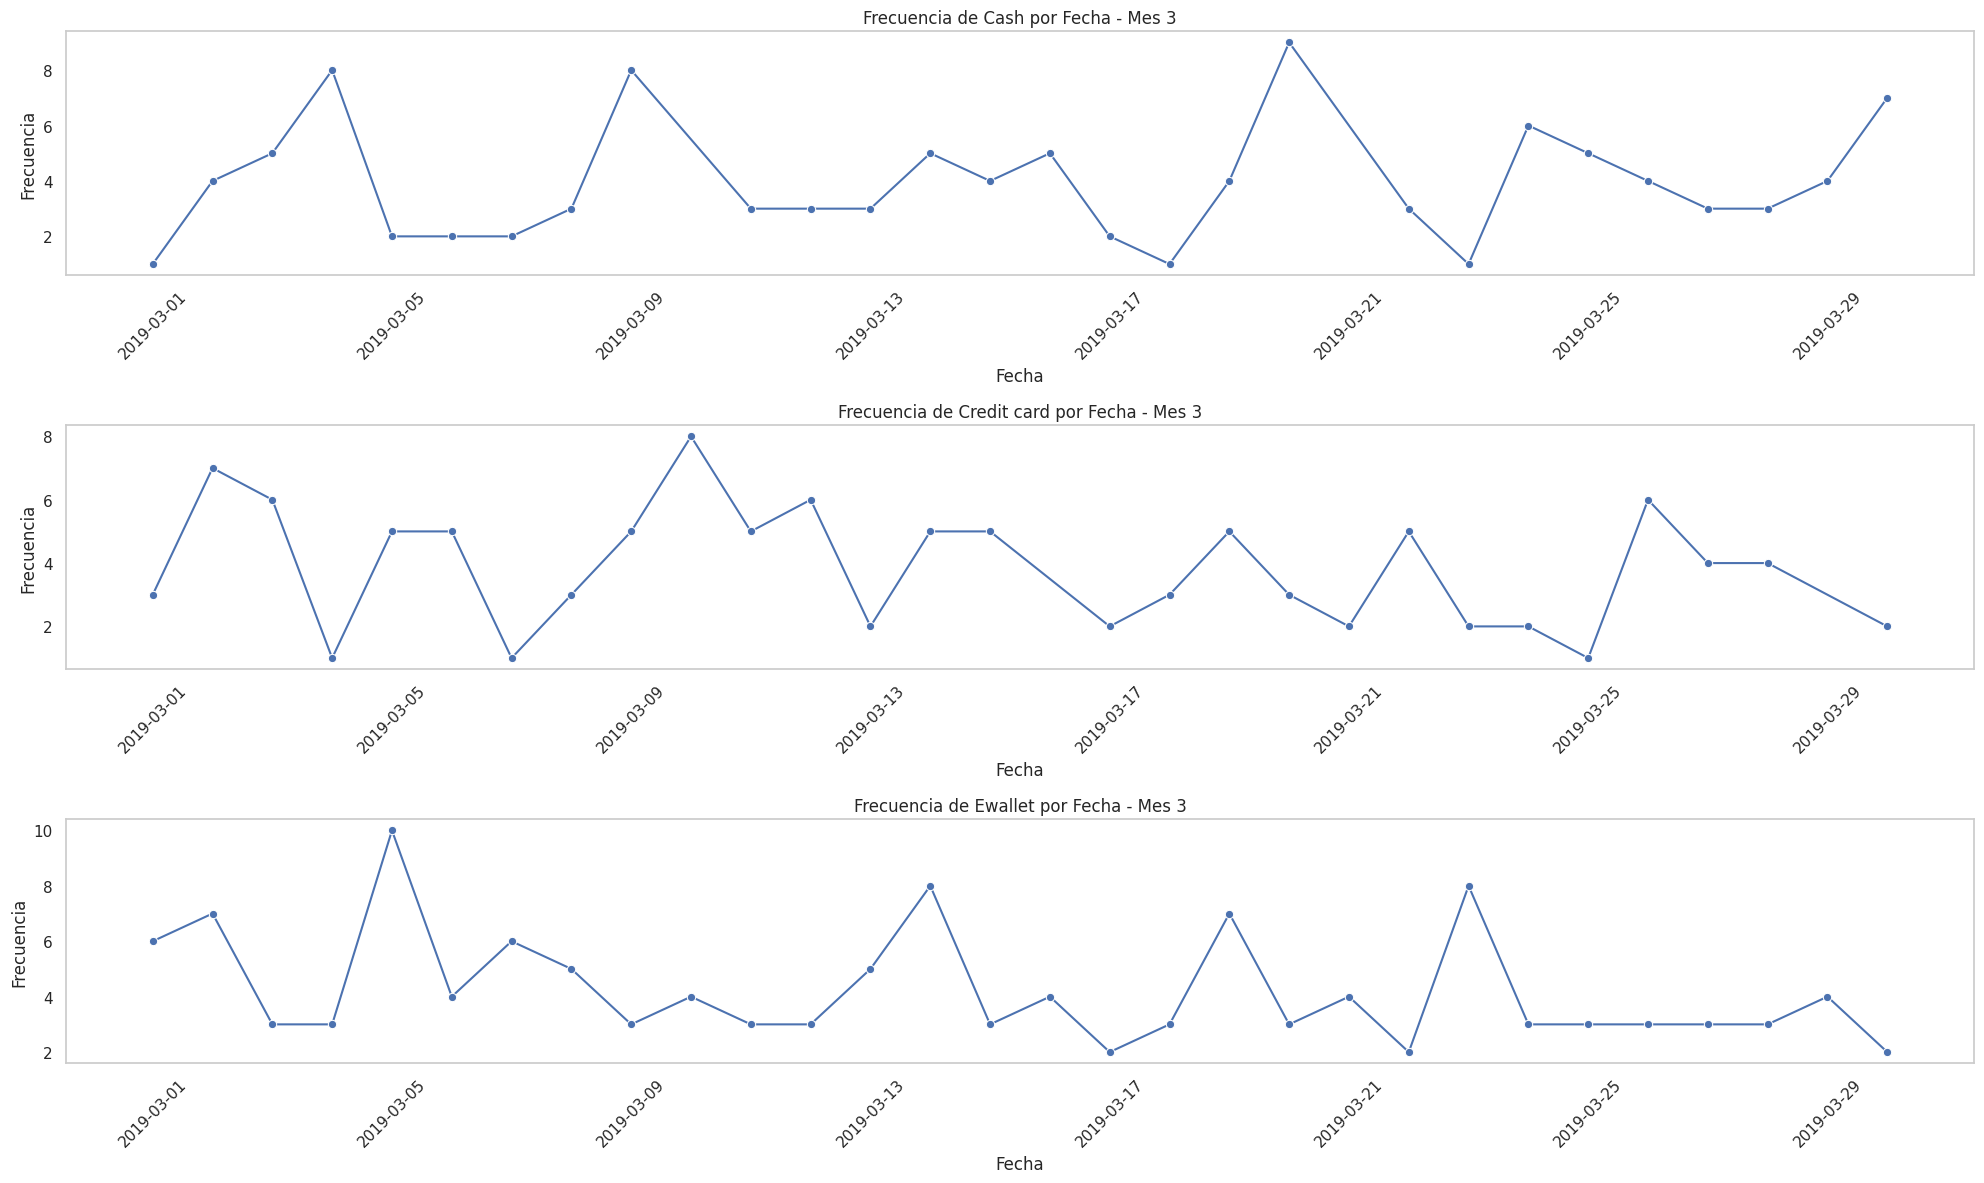

In [471]:
# Convertir columna 'Date' a tipo datetime
frecuencias_payment_fecha['Date'] = pd.to_datetime(frecuencias_payment_fecha['Date'])

# Llamadas
graficar_frecuencias_payment_mes(frecuencias_payment_fecha, 1)
graficar_frecuencias_payment_mes(frecuencias_payment_fecha, 2)
graficar_frecuencias_payment_mes(frecuencias_payment_fecha, 3)


In [472]:
# Crear columna 'Mes' si no existe
if 'Mes' not in df_pandas.columns:
    df_pandas['Mes'] = df_pandas['DateTime'].dt.month

# Calcular el promedio de ventas por método de pago y mes
promedio_ventas_payment_mes = df_pandas.groupby(['Mes', 'Payment'])['Total'].mean().reset_index()
promedio_ventas_payment_mes.columns = ['Mes', 'Método de Pago', 'Promedio de Ventas']
promedio_ventas_payment_mes['Promedio de Ventas'] = promedio_ventas_payment_mes['Promedio de Ventas'].round(2)
promedio_ventas_payment_mes

,Mes,Método de Pago,Promedio de Ventas
0,1,Cash,342.38
1,1,Credit card,338.47
2,1,Ewallet,310.04
3,2,Cash,319.16
4,2,Credit card,348.44
5,2,Ewallet,298.15
6,3,Cash,315.37
7,3,Credit card,288.52
8,3,Ewallet,343.35


La comparación del promedio de ventas por método de pago y mes revela que no existe un método claramente dominante en términos de monto promedio de ventas, ya que los tres métodos (`Cash`, `Credit card` y `Ewallet`) presentan valores similares y varían ligeramente entre los meses. Esto sugiere que los clientes utilizan de manera equilibrada las diferentes opciones de pago disponibles.

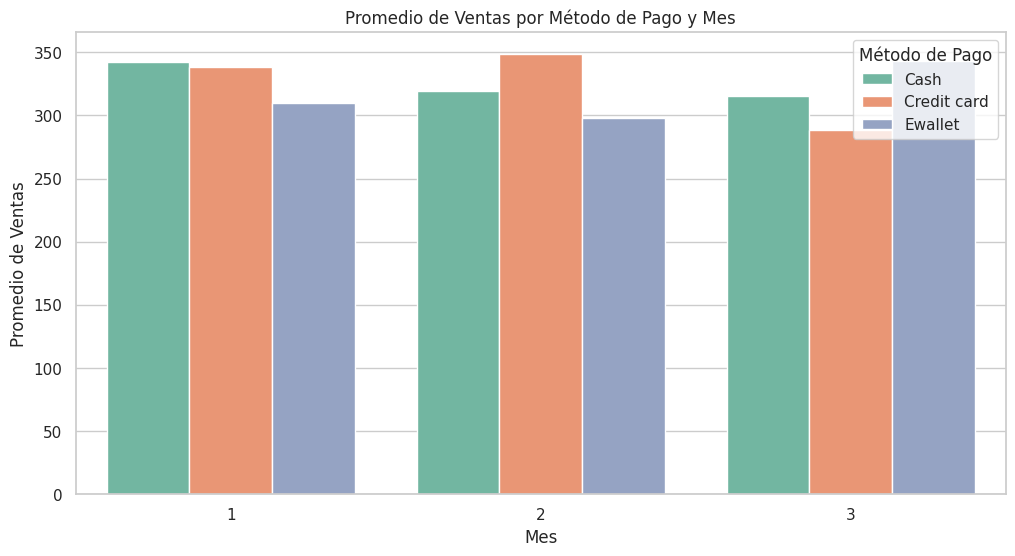

In [473]:
#  ----- *** Graficar el promedio de ventas por método de pago y mes *** -----
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='Mes', y='Promedio de Ventas', hue='Método de Pago', data=promedio_ventas_payment_mes, palette='Set2')
plt.title('Promedio de Ventas por Método de Pago y Mes')
plt.xlabel('Mes')
plt.ylabel('Promedio de Ventas')
plt.legend(title='Método de Pago')
plt.show()
# ----------- *** Fin de la visualización *** -----------

#### 7.  **Análisis de Correlación Numérica:**

**Objetivo:** Explorar relaciones lineales entre variables numéricas (`Unit price`, `Quantity`, `Tax 5%`, `Total`, `cogs`, `gross income`, `Rating`).

In [474]:
# ----- *** Crear correlacion entre las variables Unit price, Quantity, Tax %, Total, cogs, gross income y Rating *** -----
correlation_matrix = df_pandas[['Unit price', 'Quantity', 'Tax 5%', 'Total', 'cogs', 'gross income', 'Rating']].corr()
correlation_matrix

,Unit price,Quantity,Tax 5%,Total,cogs,gross income,Rating
Unit price,1.000000,0.010778,0.633962,0.633962,0.633962,0.633962,-0.008778
Quantity,0.010778,1.000000,0.705510,0.705510,0.705510,0.705510,-0.015815
Tax 5%,0.633962,0.705510,1.000000,1.000000,1.000000,1.000000,-0.036442
Total,0.633962,0.705510,1.000000,1.000000,1.000000,1.000000,-0.036442
cogs,0.633962,0.705510,1.000000,1.000000,1.000000,1.000000,-0.036442
gross income,0.633962,0.705510,1.000000,1.000000,1.000000,1.000000,-0.036442
Rating,-0.008778,-0.015815,-0.036442,-0.036442,-0.036442,-0.036442,1.000000


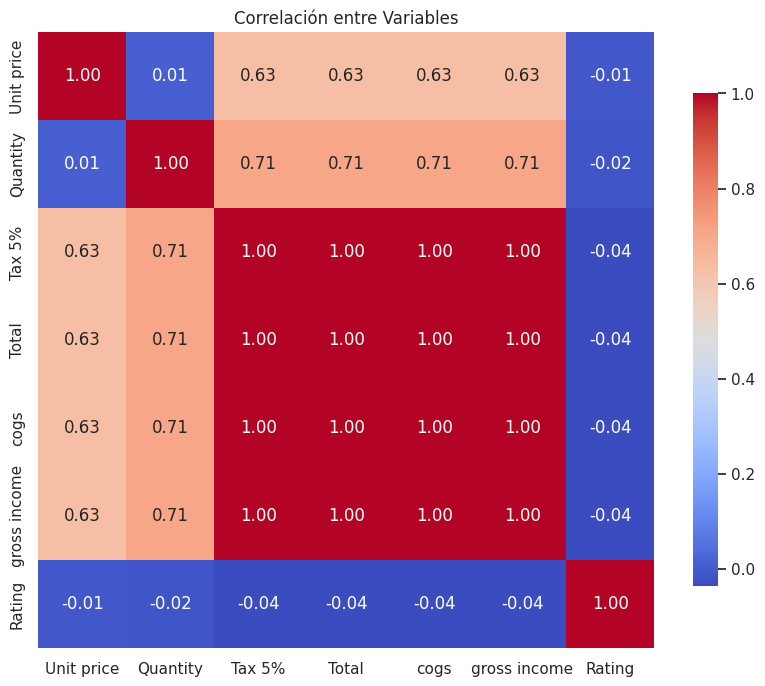

In [475]:
# ----- *** Graficar correlacion *** -----
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlación entre Variables')
plt.show()

La fuerte correlación observada entre las variables `gross income`, `cogs`, `Total` y `Tax 5%` es consecuencia directa de su naturaleza derivada: todas ellas se calculan a partir de los valores de `Unit price` y `Quantity`. Por lo tanto, la relación lineal entre estas columnas era previsible y responde a la propia estructura del dataset, no a una asociación significativa desde el punto de vista analítico. En consecuencia, no es apropiado extraer conclusiones matemáticas sobre correlaciones entre estas variables, ya que no aportan información adicional relevante para el análisis del comportamiento de ventas o clientes.

#### 8.  **Composición del Ingreso Bruto por Sucursal y Línea de Producto:**

**Objetivo:** Mostrar la contribución de cada `Product line` al `gross income` dentro de cada `Branch`.

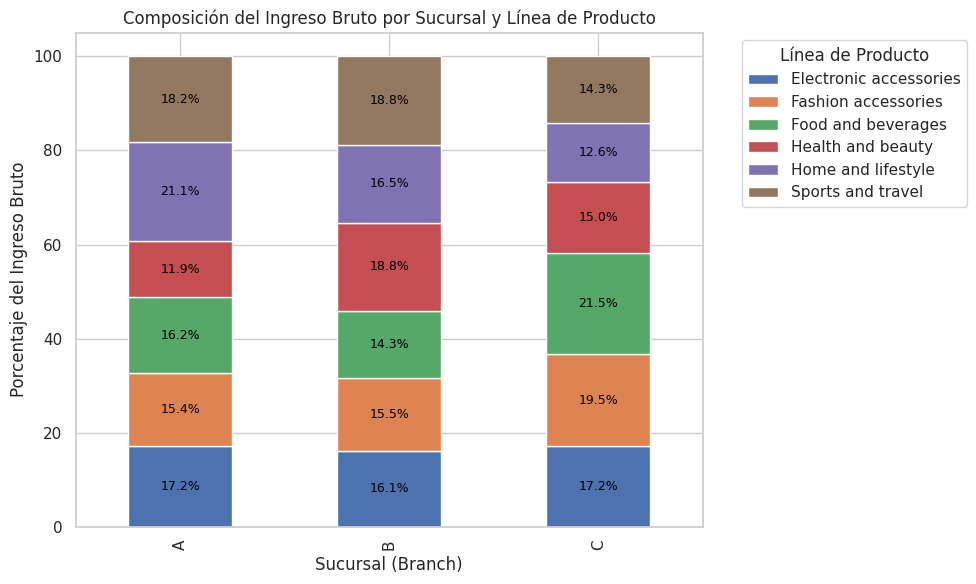

In [476]:
# Graficar con etiquetas de porcentaje en cada barra interna
ax = pivot_income.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Composición del Ingreso Bruto por Sucursal y Línea de Producto')
plt.ylabel('Porcentaje del Ingreso Bruto')
plt.xlabel('Sucursal (Branch)')
plt.legend(title='Línea de Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Añadir etiquetas de porcentaje a cada barra interna
for i, branch in enumerate(pivot_income.index):
    y_offset = 0
    for j, product in enumerate(pivot_income.columns):
        value = pivot_income.loc[branch, product]
        if value > 0:
            ax.text(
                i, 
                y_offset + value / 2, 
                f"{value:.1f}%", 
                ha='center', va='center', fontsize=9, color='black'
            )
            y_offset += value

plt.show()

## Requisitos Adicionales:
*   Implementación en Streamlit.
*   Gráficos claros (títulos, etiquetas).
*   Interactividad (filtros) donde sea apropiado.
*   Aplicación de buenas prácticas de visualización (claridad).

## 2. Integración en un Dashboard (Streamlit)

a.  Utilizando Streamlit, integren **algunas** de sus visualizaciones y hallazgos clave en un dashboard interactivo.

b.  Asegúrense de que el dashboard sea intuitivo y bien organizado (usen títulos, texto explicativo, widgets interactivos como sliders o selectores para filtrar datos).

c.  Reflexionen sobre cómo la interactividad del dashboard mejora la experiencia del usuario y el proceso de toma de decisiones basado en los datos presentados.

**Instrucciones:**
1.  Escriban el código completo de su aplicación Streamlit en la celda de código de abajo.
2.  Copien ese código a un archivo de texto simple llamado `dashboard_tarea.py` (o el nombre que prefieran).
3.  Abran una terminal o Anaconda Prompt, naveguen a la carpeta donde guardaron el archivo.
4.  Ejecuten el comando: `streamlit run dashboard_tarea.py`
5.  Interactúen con su dashboard en el navegador.
6.  **Importante:** En la celda de Markdown siguiente, describan su dashboard, qué visualizaciones incluye, qué interacciones permite, y adjunten el código de su script de python.

In [477]:
# --- Describan su Dashboard (Gráficos Utilizados y Justificación de su uso) --- 

''' ESCRIBIR AQUÍ SU DESCRIPCIÓN DEL DASHBOARD'''

' ESCRIBIR AQUÍ SU DESCRIPCIÓN DEL DASHBOARD'

In [478]:
# --- CÓDIGO PARA dashboard_tarea_grupo_X.py --- 
# (Este bloque NO se ejecuta directamente en Jupyter)

''' PEGAR A CONTINUACIÓN EL CÓDIGO DEL DASHBOARD '''

' PEGAR A CONTINUACIÓN EL CÓDIGO DEL DASHBOARD '

# 3. Deployment

a.  Desplieguen su dashboard en Streamlit Cloud.

b.  Asegúrense de que el dashboard sea accesible públicamente.

c.  Proporcionen el enlace al dashboard desplegado en la celda de Markdown siguiente.

d.  Reflexionen sobre el proceso de despliegue y cualquier desafío que hayan enfrentado.


En el caso que no hayan podido deployar:

In [479]:
'''
Comentar si hubo problemas con el código o si no se ejecutó correctamente que les impidieron realizar el análisis completo y el deployment del dashboard.
'''

'\nComentar si hubo problemas con el código o si no se ejecutó correctamente que les impidieron realizar el análisis completo y el deployment del dashboard.\n'

En el caso que hayan podido deployar:

In [480]:
'''
Poner aquí la url de su dashboard en el servidor de Streamlit.
Ejemplo: https://share.streamlit.io/streamlit/demo-uber-nyc-pickups
'''

'\nPoner aquí la url de su dashboard en el servidor de Streamlit.\nEjemplo: https://share.streamlit.io/streamlit/demo-uber-nyc-pickups\n'

# 4. Conclusiones Generales

Reflexionen sobre el proceso de análisis y visualización. ¿Qué aprendieron sobre los datos de la tienda? ¿Qué limitaciones encontraron en los datos o en las técnicas de visualización? ¿Qué recomendaciones (basadas en los datos) podrían darle a la cadena de tiendas?

In [481]:
'''
Escriban acá su reflexión sobre el Dashboard.
'''

'\nEscriban acá su reflexión sobre el Dashboard.\n'

# 5. Referencias

Listar las fuentes utilizadas (dataset, bibliotecas principales, material de referencia adicional si aplica).

In [482]:
'''
Escriban aquí las referencias.
'''

'\nEscriban aquí las referencias.\n'

## NOTA FINAL:
### Asegúrense de sólo subir el jupyter notebook a la plataforma, con un formato del tipo: "Trabajo_Grupo_X.ipynb".
### No es necesario incluir el archivo .py del dashboard, pero sí el código dentro de este cuaderno en el apartado correspondiente.